# 0. 기본 정보
* 코드 작성자: 여서연
* 코드 작성일: 2024-05-06 ~ 2024-05-10
* 데이터 분석 목적: 크롤링 대상 적합성 판정

# 1. 기초 설정

## 사용 라이브러리

In [ ]:
# 크롤링

from googleapiclient.discovery import build
import pandas as pd
from dotenv import load_dotenv
import os

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# NLP
import konlpy
from konlpy.tag import *
okt = Okt()
from konlpy.utils import pprint
from collections import Counter

In [ ]:
# 워드 클라우드
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import matplotlib.pyplot as plt
font_path = 'C:/Windows/Fonts/malgun.ttf'

## 기타 설정

In [ ]:
# 데이터 프레임 열 전부 표시
pd.set_option('display.max_columns', None)

In [ ]:
load_dotenv()
myKEY = os.environ.get('GOOGLE_API_KEY')

url = 'https://www.youtube.com/watch?v=4mXfGe-jzYs'

# 2. 유튜브 댓글 크롤링
* [코드 출처](https://velog.io/@jihyunko/python-%EC%9C%A0%ED%8A%9C%EB%B8%8C-%EB%8C%93%EA%B8%80-%ED%81%AC%EB%A1%A4%EB%A7%81)
* [참조](https://developers.google.com/youtube/v3/docs/commentThreads/list?hl=ko)

## API test

In [ ]:
# 영상 주소에서 video id 추출
video_id = url[-11:]

In [ ]:
# API 불러오기
api = build('youtube', 'v3', developerKey = myKEY)
# API 요청
request = api.commentThreads().list(
    part="id, replies, snippet",
    maxResults=100, #최대 항목 수
    moderationStatus="published", #댓글 공개 범위 - 공개된 것만
    order="time", #시간순 정렬
    textFormat="html", #반환 형식 - html
    videoId=video_id #대상 동영상
    )
# API 실행
response = request.execute()

print(response)

In [ ]:
# html을 데이터 프레임으로 확인
result = pd.json_normalize(response)
result

In [ ]:
# 반환값 중 items 항목 구체적으로 확인
item = pd.json_normalize(response['items'])
item.sample()

In [ ]:
# 리스트 저장
comments = list()
for items in response['items']:
    comment = items['snippet']['topLevelComment']['snippet']['textDisplay']
    comments.append(comment)

comments[0]

In [ ]:
# 답글이 있는 경우

for i in range(len(item)):
    if item['snippet.totalReplyCount'][i] > 0:
        print(item['replies.comments'][i])

In [ ]:
# 다음 페이지
next_request = api.commentThreads().list(
    part="id, replies, snippet",
    maxResults=100,
    moderationStatus="published",
    order="time",
    textFormat="html",
    videoId=video_id,
    pageToken=request.execute()['nextPageToken'] #고유 토큰 추출
    )
next_response = next_request.execute()
next_item = pd.json_normalize(next_response['items'])
next_item.sample()

## 함수 소개
* YoutubeCommentCrawl(key, url, max=100)
    * key: Google Cloud API에서 발급 받은 API 키
    * url: 댓글을 크롤링할 주소 (단, 상단바에서 복사할 것)
    * max: 결과 집합에 반환해야 하는 최대 항목 수 (1 ~ 100)

In [ ]:
def YoutubeCommentCrawl(key, url, max=100):
    video_id = url[-11:]
    comments = list() #댓글을 담을 리스트
    api = build('youtube', 'v3', developerKey=key) #API name, version, key
    request = api.commentThreads().list(
        part="replies, snippet",
        maxResults=max,
        moderationStatus="published",
        order="time",
        textFormat="html",
        videoId=video_id
        )
    response = request.execute()

    while response:
        # 댓글 추출
        for item in response['items']:
            comment = item['snippet']['topLevelComment']['snippet']['textDisplay']
            comments.append(comment)

            # 답글 추출
            if item['snippet']['totalReplyCount'] > 0: #답글이 1개 이상인 경우
                for reply_item in item['replies']['comments']:
                    reply = reply_item['snippet']['textDisplay']
                    comments.append(reply)

        # 다음 페이지
        if 'nextPageToken' in response:
            # response를 새로 할당하여 계속 순회
            response = api.commentThreads().list(
                part="replies, snippet",
                maxResults=max,
                moderationStatus="published",
                order="time",
                textFormat="html",
                videoId=video_id,
                pageToken=response['nextPageToken']
                ).execute()
        else:
            break

    df = pd.DataFrame(comments, columns=['comment'])
    return df

In [ ]:
df = YoutubeCommentCrawl(myKEY, url)
df.sample()

# 3. NLP

In [ ]:
def NLP(df, col):
    text = list(df[col])
    result = ' '.join(z for z in text)
    okt_pos = okt.pos(result, norm=True, stem=True)
    tm = [x for x,y in okt_pos if y in ['Noun', 'Adjective', 'Adverb']]

    for i,j in enumerate(tm):
        if len(j) < 2:
            tm.pop(i)

    word_freq_dict = dict(Counter(tm))

    return word_freq_dict

In [ ]:
word = NLP(df, 'comment')

## wordcloud

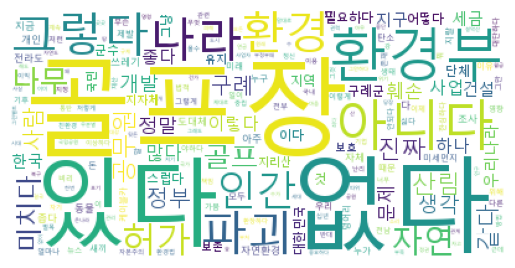

In [17]:
wc = WordCloud(background_color='white', random_state=0,
               font_path=font_path)
plt.imshow(wc.generate_from_frequencies(word))
plt.axis('off')
plt.show()